# Gravitar PPO: LR = 2e-4, 500 episodes, num_envs = 4

In [16]:
!nvidia-smi

Sat May  4 22:13:02 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   29C    P0    35W / 250W |   1513MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installing necessary packages

In [17]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


In [18]:
!pip install utils

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


# Importing necessary libraries

In [19]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

from stable_baselines3.common.atari_wrappers import ClipRewardEnv, FireResetEnv, MaxAndSkipEnv, NoopResetEnv

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
gym.envs.registration.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV26Environment-v0', 'GymV21Environment-v0', 'Adventure-v0', 'AdventureDeterministic-v0', 'AdventureNoFrameskip-v0

In [21]:
def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()

    plt.clf()
    plt.close()

# defining the parameters, functions and training loop - grouped 

In [22]:
ENV_ARGS = {
    'id': "GravitarDeterministic-v4"
}
NUM_ENVS = 4
SEED = 1
LR = 2e-4
NUM_STEPS = 5000
NUM_ITERATIONS = 500
GAMMA = 0.99
GAE_LAMBDA = 0.95
UPDATE_EPOCHS = 10
CLIP_COEF = 0.2
ENTROPY_COEF = 0.0
VF_COEF = 0.5
MAX_GRAD_NORM = 0.5
MINI_BATCH_COUNT = 64
UPDATE_PLOTS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', DEVICE)

# Output directory
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output')

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
# Seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

def make_env(**env_args):
    env = gym.make(**env_args)
    # env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip = 4)

    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84,84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = gym.wrappers.FrameStack(env, 4)
    return env

def layer_init(layer: nn.Linear, std = np.sqrt(2), bias_const = 0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):

    def __init__(self, envs: gym.Env, hidden_size: int = 512):

        super().__init__()

        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride = 4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride = 2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride = 1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, hidden_size)),
            nn.ReLU(),
        )

        self.actor = layer_init(nn.Linear(hidden_size, envs.single_action_space.n), std = 0.01)
        self.critic = layer_init(nn.Linear(hidden_size,1 ), std = 1.0)

    def get_value(self, x):
        return self.critic(self.network(x/255.0))

    def get_action_and_value(self, x, action = None):
        '''
        @params:
            x: torch.tensor observation, shape = (N, observation size)
            action: torch.tensor action
        @returns:
            action: torch.tensor, shape = (N, action size)
            log_prob: torch.tensor, shape = (N,)
            entropy: torch.tensor, shape = (N,)
            value: torch.tensor, shape = (N,)
        '''

        hidden = self.network(x/255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action == None:
            action = probs.sample()

        log_prob = probs.log_prob(action)
        entropy = probs.entropy()
        value = self.critic(hidden)
        return action, log_prob, entropy, value

# Create env
envs = gym.vector.AsyncVectorEnv(
    [lambda: make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
)

agent = Agent(envs).to(DEVICE)
optimizer = torch.optim.AdamW(agent.parameters(), lr=LR, eps=1e-5, amsgrad=True)

M = NUM_STEPS
N = NUM_ENVS

label = str(uuid.uuid4()).split('-')[0]
print('run id = ', label)

SAVE_PATH = os.path.join(OUTPUT, label)
FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot_gravitar_inst4.png')
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

obs = torch.zeros((M, N) + envs.single_observation_space.shape, device=DEVICE)
actions = torch.zeros((M, N) + envs.single_action_space.shape, device=DEVICE)
log_probs = torch.zeros((M, N), device=DEVICE)
rewards = torch.zeros((M, N), device=DEVICE)
dones = torch.zeros((M, N), device=DEVICE)  # for masking
values = torch.zeros((M, N), device=DEVICE)

global_step = 0

next_obs, _ = envs.reset()
next_obs = torch.tensor(next_obs, device=DEVICE)
next_done = torch.zeros(N, device=DEVICE)  # N is num envs

print('next obs = ', next_obs.shape)
print('next done = ', next_done.shape)

reward_window = deque(maxlen=100)
history = defaultdict(list)

loop = tqdm(range(NUM_ITERATIONS))
agent.train()

best_score = float('-inf')
evaluation = 0
loss = float('inf')

for iter in loop:
    if iter % UPDATE_PLOTS == 0:
        plot(history, save_path=FIG_SAVE_PATH)

    for step in range(M):
        global_step += N

        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()

        actions[step] = action
        log_probs[step] = log_prob

        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        next_done = torch.logical_or(torch.tensor(terminated), torch.tensor(truncated)).to(DEVICE)

        rewards[step] = torch.tensor(reward, device=DEVICE).view(-1)
        next_obs = torch.tensor(next_obs, device=DEVICE)

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r']
                    reward_window.append(reward)
                    avg_reward = torch.tensor(list(reward_window)).mean().item()
                    history['reward'].append(avg_reward)
                    loop.set_description(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Loss = {loss:.2f}, Steps = {step}")

                    if best_score < avg_reward:
                        best_score = avg_reward
                        torch.save(agent.state_dict(), os.path.join(SAVE_PATH, 'ppo.checkpoint_gravitarv4_inst4.torch'))

# Continue with optimization phase
        # OPTIMIZE phase:
    with torch.no_grad():
        # Bootstrap values, compute returns
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards, device=DEVICE)
        last_gae_lam = 0

        for t in reversed(range(M)):
            if t == M - 1:
                next_non_terminal = 1.0 - next_done.float()
                next_values = next_value
            else:
                next_non_terminal = 1.0 - dones[t + 1].float()
                next_values = values[t + 1]

            # GAE-Lambda advantage calculation
            delta = rewards[t] + GAMMA * next_values * next_non_terminal - values[t]
            advantages[t] = last_gae_lam = delta + GAMMA * GAE_LAMBDA * next_non_terminal * last_gae_lam

            # Compute returns by adding values to advantages
        returns = advantages + values

    # Flatten the tensors to prepare for mini-batch gradient descent
    b_obs = obs.view((-1,) + envs.single_observation_space.shape)
    b_actions = actions.view((-1,) + envs.single_action_space.shape)
    b_log_probs = log_probs.view(-1)
    b_advantages = advantages.view(-1)
    b_returns = returns.view(-1)
    b_values = values.view(-1)

    # Batch indices preparation for mini-batch updates
    batch_size = M * N
    mini_batch_size = batch_size // MINI_BATCH_COUNT
    b_indices = torch.arange(batch_size, device=DEVICE)
    clip_fracs = []

    for epoch in range(UPDATE_EPOCHS):
        # Shuffle batch indices to decorrelate the batches
        b_indices = b_indices[torch.randperm(batch_size)]

        for start in range(0, batch_size, mini_batch_size):
            end = start + mini_batch_size
            mini_indices = b_indices[start:end]

            _, new_log_prob, entropy, new_value = agent.get_action_and_value(b_obs[mini_indices], b_actions[mini_indices])

            # Policy gradient loss calculation
            log_ratio = new_log_prob - b_log_probs[mini_indices]
            ratio = torch.exp(log_ratio)

            # Calculate surrogate losses - there is with torch.no_grad() missing here to approximate KL
            surr1 = ratio * b_advantages[mini_indices]
            surr2 = torch.clamp(ratio, 1.0 - CLIP_COEF, 1.0 + CLIP_COEF) * b_advantages[mini_indices]
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss using mean squared error
            value_loss = 0.5 * (new_value.view(-1) - b_returns[mini_indices]).pow(2).mean()

            # Total loss
            loss = policy_loss + VF_COEF * value_loss - ENTROPY_COEF * entropy.mean()

            # Perform gradient descent step
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), MAX_GRAD_NORM)
            optimizer.step()

            # Optional: collect information about clipping
            clip_frac = ((ratio - 1.0).abs() > CLIP_COEF).float().mean().item()
            clip_fracs.append(clip_frac)

# Final evaluation and model saving after training
#evaluation = evaluate(agent)  # Assuming evaluate function returns a scalar or a tensor
#print('Final evaluation score:', evaluation)
torch.save(agent.state_dict(), os.path.join(SAVE_PATH, 'ppo.final_gravitarv4_inst4.torch'))


device =  cuda
run id =  bc69c205
next obs =  torch.Size([4, 4, 84, 84])
next done =  torch.Size([4])


Reward = 2161.50, Global Step = 9999936, Best Score = 2334.00, Loss = 0.06, Steps = 4983: 100%|██████████| 500/500 [12:12:10<00:00, 87.86s/it]   


# Evaluation

In [49]:
import torch

def evaluate(agent, episodes=5):
    # Create a synchronous vector environment
    envs = gym.vector.SyncVectorEnv([lambda: make_env(**ENV_ARGS) for _ in range(NUM_ENVS)])
    
    agent.eval()
    #obs, _ = envs.reset()
    #obs = torch.tensor(obs, dtype=torch.float32).to(DEVICE)  # Convert observations to tensors
    obs = torch.zeros((M, N) + envs.single_observation_space.shape, device=DEVICE)
    next_obs, _ = envs.reset()
    next_obs = torch.tensor(next_obs, device=DEVICE)
    next_done = torch.zeros(N, device=DEVICE)
    
    test_reward_window = deque(maxlen=5)
    test_history = defaultdict(list)
    episode_counts = 0
    test_global_step = 0
        
    while episode_counts < episodes:
        episode_counts += 1
        for step in range(M):
            test_global_step += N

            obs[step] = next_obs
            dones[step] = next_done

            with torch.no_grad():
                action, log_prob, _, value = agent.get_action_and_value(next_obs)
                values[step] = value.flatten()

            actions[step] = action
            log_probs[step] = log_prob

            next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
            next_done = torch.logical_or(torch.tensor(terminated), torch.tensor(truncated)).to(DEVICE)

            rewards[step] = torch.tensor(reward, device=DEVICE).view(-1)
            next_obs = torch.tensor(next_obs, device=DEVICE)

            if 'final_info' in info:
                for data in info['final_info']:
                    if data:
                        reward = data['episode']['r']
                        test_reward_window.append(reward)
                        test_avg_reward = torch.tensor(list(test_reward_window)).mean().item()
                        test_history['reward'].append(test_avg_reward)
                        #loop.set_description(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Loss = {loss:.2f}, Steps = {step}")
                        #print(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Steps = {step}")
        print(f"Episode:{episode_counts}, Reward:{test_avg_reward}, Steps:{step}")
        

evaluate(agent,5)

Episode:1, Reward:2020.0, Steps:4999
Episode:2, Reward:2230.0, Steps:4999
Episode:3, Reward:2260.0, Steps:4999
Episode:4, Reward:2280.0, Steps:4999
Episode:5, Reward:2350.0, Steps:4999


Episode:1, Reward:2030.0
Episode:2, Reward:1990.0
Episode:3, Reward:2040.0
Episode:4, Reward:2040.0
Episode:5, Reward:2060.0


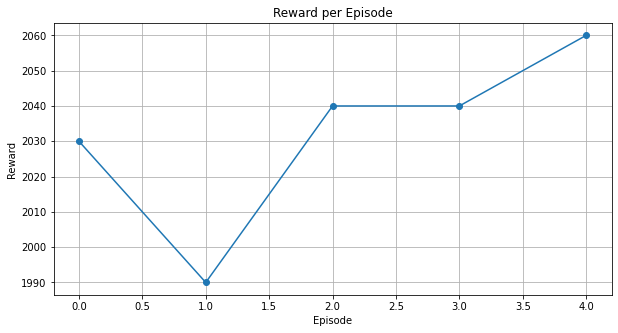

Evaluation Average Reward: 2032.0


In [54]:
test_agent = agent

def evaluate(agent, episodes=5):
    # Create a synchronous vector environment
    envs = gym.vector.SyncVectorEnv([lambda: make_env(**ENV_ARGS) for _ in range(NUM_ENVS)])
    
    agent.eval()
    #obs, _ = envs.reset()
    #obs = torch.tensor(obs, dtype=torch.float32).to(DEVICE)  # Convert observations to tensors
    obs = torch.zeros((M, N) + envs.single_observation_space.shape, device=DEVICE)
    next_obs, _ = envs.reset()
    next_obs = torch.tensor(next_obs, device=DEVICE)
    next_done = torch.zeros(N, device=DEVICE)
    
    test_reward_window = deque(maxlen=5)
    test_history = defaultdict(list)
    episode_counts = 0
    test_global_step = 0
    test_episode_rewards = []
        
    while episode_counts < episodes:
        episode_counts += 1
        for step in range(M):
            test_global_step += N

            obs[step] = next_obs
            dones[step] = next_done

            with torch.no_grad():
                action, log_prob, _, value = agent.get_action_and_value(next_obs)
                values[step] = value.flatten()

            actions[step] = action
            log_probs[step] = log_prob

            next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
            next_done = torch.logical_or(torch.tensor(terminated), torch.tensor(truncated)).to(DEVICE)

            rewards[step] = torch.tensor(reward, device=DEVICE).view(-1)
            next_obs = torch.tensor(next_obs, device=DEVICE)

            if 'final_info' in info:
                for data in info['final_info']:
                    if data:
                        reward = data['episode']['r']
                        test_reward_window.append(reward)
                        test_avg_reward = torch.tensor(list(test_reward_window)).mean().item()
                        test_history['reward'].append(test_avg_reward)
                        #loop.set_description(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Loss = {loss:.2f}, Steps = {step}")
                        #print(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Steps = {step}")
        print(f"Episode:{episode_counts}, Reward:{test_avg_reward}")
        test_episode_rewards.append(test_avg_reward)
    return test_episode_rewards
        

# Assuming 'evaluate' function is already defined and working correctly
rewards_test = evaluate(test_agent, episodes=5)

# Plotting the rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_test, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

# Calculate and print the average reward
average_reward = np.mean(rewards_test)
print("Evaluation Average Reward:", average_reward)


Episode:1, Reward:1760.0
Episode:2, Reward:2550.0
Episode:3, Reward:1410.0
Episode:4, Reward:2130.0
Episode:5, Reward:2380.0
Episode:6, Reward:2180.0
Episode:7, Reward:2310.0
Episode:8, Reward:2300.0
Episode:9, Reward:1990.0
Episode:10, Reward:1590.0


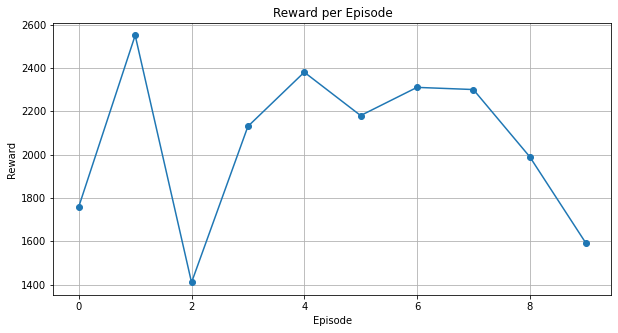

Evaluation Average Reward: 2060.0


In [56]:
rewards_test = evaluate(test_agent, episodes=10)

# Plotting the rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_test, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

# Calculate and print the average reward
average_reward = np.mean(rewards_test)
print("Evaluation Average Reward:", average_reward)

Episode:1, Reward:2070.0
Episode:2, Reward:2410.0
Episode:3, Reward:2200.0
Episode:4, Reward:1200.0
Episode:5, Reward:1690.0
Episode:6, Reward:2210.0
Episode:7, Reward:2260.0
Episode:8, Reward:1940.0
Episode:9, Reward:2380.0
Episode:10, Reward:2470.0


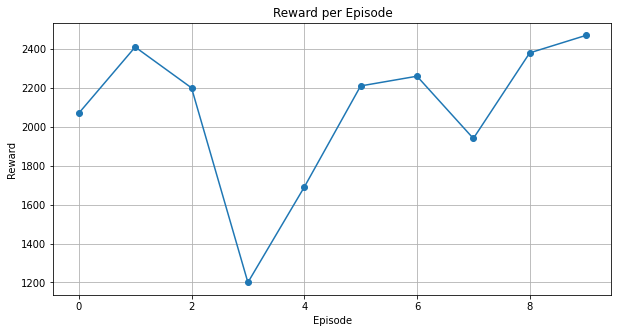

Evaluation Average Reward: 2083.0


In [57]:
rewards_test = evaluate(test_agent, episodes=10)

# Plotting the rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_test, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

# Calculate and print the average reward
average_reward = np.mean(rewards_test)
print("Evaluation Average Reward:", average_reward)

Episode:1, Reward:2020.0
Episode:2, Reward:2140.0
Episode:3, Reward:1690.0
Episode:4, Reward:2380.0
Episode:5, Reward:2340.0
Episode:6, Reward:2020.0
Episode:7, Reward:2420.0
Episode:8, Reward:2220.0
Episode:9, Reward:1920.0
Episode:10, Reward:2500.0
Episode:11, Reward:2040.0
Episode:12, Reward:1800.0
Episode:13, Reward:2380.0
Episode:14, Reward:2020.0
Episode:15, Reward:2410.0
Episode:16, Reward:2530.0
Episode:17, Reward:2390.0
Episode:18, Reward:2050.0
Episode:19, Reward:2470.0
Episode:20, Reward:2400.0


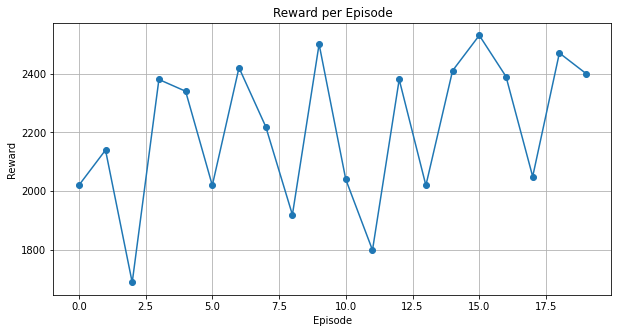

Evaluation Average Reward: 2207.0


In [58]:
rewards_test = evaluate(test_agent, episodes=20)

# Plotting the rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_test, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

# Calculate and print the average reward
average_reward = np.mean(rewards_test)
print("Evaluation Average Reward:", average_reward)

Episode:1, Reward:1970.0
Episode:2, Reward:2350.0
Episode:3, Reward:1720.0
Episode:4, Reward:1690.0
Episode:5, Reward:2110.0
Episode:6, Reward:1950.0
Episode:7, Reward:1740.0
Episode:8, Reward:1840.0
Episode:9, Reward:1760.0
Episode:10, Reward:2100.0


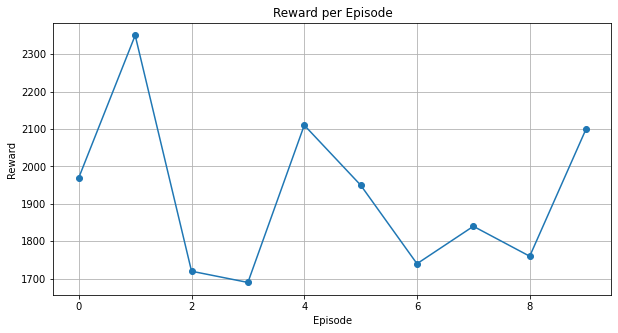

Evaluation Average Reward: 1923.0


In [61]:
test_agent = agent
NUM_ENVS = 1
N = NUM_ENVS

def evaluate(agent, episodes=10):
    # Create a synchronous vector environment
    envs = gym.vector.SyncVectorEnv([lambda: make_env(**ENV_ARGS) for _ in range(NUM_ENVS)])
    
    agent.eval()
    #obs, _ = envs.reset()
    #obs = torch.tensor(obs, dtype=torch.float32).to(DEVICE)  # Convert observations to tensors
    obs = torch.zeros((M, N) + envs.single_observation_space.shape, device=DEVICE)
    next_obs, _ = envs.reset()
    next_obs = torch.tensor(next_obs, device=DEVICE)
    next_done = torch.zeros(N, device=DEVICE)
    
    test_reward_window = deque(maxlen=5)
    test_history = defaultdict(list)
    episode_counts = 0
    test_global_step = 0
    test_episode_rewards = []
        
    while episode_counts < episodes:
        episode_counts += 1
        for step in range(M):
            test_global_step += N

            obs[step] = next_obs
            dones[step] = next_done

            with torch.no_grad():
                action, log_prob, _, value = agent.get_action_and_value(next_obs)
                values[step] = value.flatten()

            actions[step] = action
            log_probs[step] = log_prob

            next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
            next_done = torch.logical_or(torch.tensor(terminated), torch.tensor(truncated)).to(DEVICE)

            rewards[step] = torch.tensor(reward, device=DEVICE).view(-1)
            next_obs = torch.tensor(next_obs, device=DEVICE)

            if 'final_info' in info:
                for data in info['final_info']:
                    if data:
                        reward = data['episode']['r']
                        test_reward_window.append(reward)
                        test_avg_reward = torch.tensor(list(test_reward_window)).mean().item()
                        test_history['reward'].append(test_avg_reward)
                        #loop.set_description(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Loss = {loss:.2f}, Steps = {step}")
                        #print(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Steps = {step}")
        print(f"Episode:{episode_counts}, Reward:{test_avg_reward}")
        test_episode_rewards.append(test_avg_reward)
    return test_episode_rewards
        

# Assuming 'evaluate' function is already defined and working correctly
rewards_test = evaluate(test_agent, episodes=10)

# Plotting the rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_test, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

# Calculate and print the average reward
average_reward = np.mean(rewards_test)
print("Evaluation Average Reward:", average_reward)


# Plotting training curve

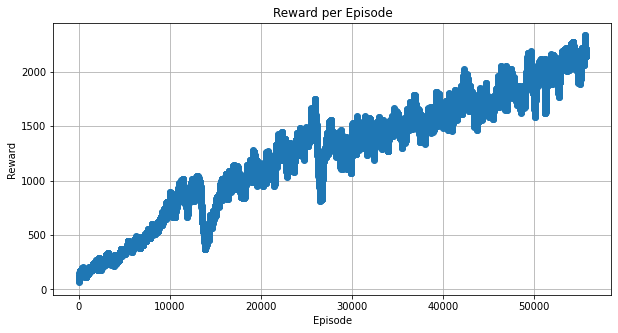

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(history['reward'], marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

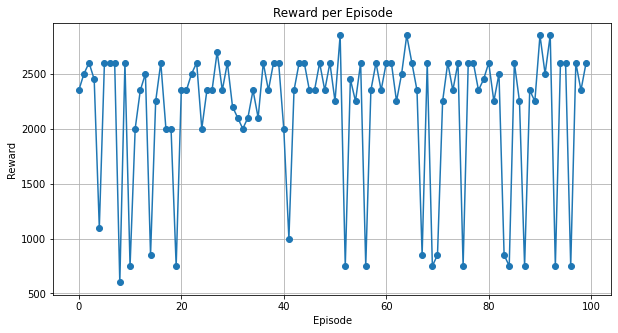

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(reward_window, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

In [62]:
test_agent = agent
NUM_ENVS = 1
N = NUM_ENVS

def evaluate(agent, episodes=1):
    # Create a synchronous vector environment
    envs = gym.vector.SyncVectorEnv([lambda: make_env(**ENV_ARGS) for _ in range(NUM_ENVS)])
    
    agent.eval()
    #obs, _ = envs.reset()
    #obs = torch.tensor(obs, dtype=torch.float32).to(DEVICE)  # Convert observations to tensors
    obs = torch.zeros((M, N) + envs.single_observation_space.shape, device=DEVICE)
    next_obs, _ = envs.reset()
    next_obs = torch.tensor(next_obs, device=DEVICE)
    next_done = torch.zeros(N, device=DEVICE)
    
    test_reward_window = deque(maxlen=5)
    test_history = defaultdict(list)
    episode_counts = 0
    test_global_step = 0
    test_episode_rewards = []
        
    while episode_counts < episodes:
        episode_counts += 1
        for step in range(M):
            test_global_step += N

            obs[step] = next_obs
            dones[step] = next_done

            with torch.no_grad():
                action, log_prob, _, value = agent.get_action_and_value(next_obs)
                values[step] = value.flatten()

            actions[step] = action
            log_probs[step] = log_prob

            next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
            next_done = torch.logical_or(torch.tensor(terminated), torch.tensor(truncated)).to(DEVICE)

            rewards[step] = torch.tensor(reward, device=DEVICE).view(-1)
            next_obs = torch.tensor(next_obs, device=DEVICE)

            if 'final_info' in info:
                for data in info['final_info']:
                    if data:
                        reward = data['episode']['r']
                        test_reward_window.append(reward)
                        test_avg_reward = torch.tensor(list(test_reward_window)).mean().item()
                        test_history['reward'].append(test_avg_reward)
                        #loop.set_description(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Loss = {loss:.2f}, Steps = {step}")
                        #print(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Steps = {step}")
        print(f"Episode:{episode_counts}, Reward:{test_avg_reward}")
        test_episode_rewards.append(test_avg_reward)
    envs.render(mode='human')
    return test_episode_rewards
        

# Assuming 'evaluate' function is already defined and working correctly
rewards_test = evaluate(test_agent, episodes=1)


Episode:1, Reward:2500.0


TypeError: render() got an unexpected keyword argument 'mode'

In [64]:
envs.render()

NotImplementedError: 

In [69]:
test_agent = agent
NUM_ENVS = 1
N = NUM_ENVS

def make_env(**env_args):
    env = gym.make(**env_args, render_mode='human')
    # env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip = 4)

    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84,84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = gym.wrappers.FrameStack(env, 4)
    return env

envs = make_env(**ENV_ARGS)


RuntimeError: Failed to initialize SDL

In [67]:
!pip install pygame

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


In [68]:
!pip install PySDL2

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 773 kB 3.8 MB/s eta 0:00:01
  Created wheel for PySDL2: filename=PySDL2-0.9.16-py3-none-any.whl size=580364 sha256=eaf98bb48d296d43ef8270eab348164b4af7abfb176a91cd955b3bfb7b849e46
  Stored in directory: /user/dgusain/.cache/pip/wheels/13/1b/d9/23c7690d53f42a79a52c1946b1f99088945ddca05949a64c77
Successfully built PySDL2
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
